In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from utilities import plotting
from utilities import stats
from utilities import timestamps
from utilities import import_export
from utilities import polygon_selection
from mpl_toolkits.basemap import Basemap
from itertools import product
import matplotlib.pyplot as plt

In [2]:
# df = pd.read_csv('data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
#                                                         , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
#                                                         , 'depth_error', 'mag_err'])
# df['timestamp'] = df.decimal_year.apply(timestamps.convert_decimal_year_to_numpy_datetime64)

df = import_export.import_catalog(location='data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])

In [3]:
# df[(df.decimal_year > 2011) & (df.mag >= 6.5) & (df.depth <= 40) & (df.lon.between(142, 143))]

In [4]:
noto_hanto = {'coordinates':(136.686000, 37.220667), 'time':'2007-03-25 00:41:57.909996', 'tz':'UTC', 'magnitude':6.9}
western_tottori = {'coordinates':(133.349, 35.274167), 'time':'2000-10-06 04:30:17.940011', 'tz':'UTC', 'magnitude':6.7}
sugura_bay = {'coordinates':(138.499333, 34.786167), 'time':'2009-08-10 20:07:05.740017', 'tz':'UTC', 'magnitude':6.5}
iwaki = {'coordinates':(140.672667, 36.945667), 'time':'2011-04-11 08:16:12.020008', 'tz':'UTC', 'magnitude':6.6}
iwate_miyage = {'coordinates':(140.880667, 39.029833), 'time':'2008-06-13 23:43:45.359992', 'tz':'UTC', 'magnitude':6.8}
kumamoto = {'coordinates':(130.763, 32.7545), 'time':'2016-04-14 12:26:00', 'tz':'UTC', 'magnitude':7.0}
tohoku = {'coordinates':(142.861000, 38.103500), 'time':'2011-03-11 05:46:18.119983', 'tz':'UTC', 'magnitude':9.0}

def plot_earthquake_on_basemap(eq, m, ax, **kwargs):
    x, y = m(eq['coordinates'][0], eq['coordinates'][1])
    ax.scatter(x, y, s=0.75*np.exp(eq['magnitude']), **kwargs)
    ax.annotate('{year} M{mag}'.format(year=np.datetime64(eq['time']).astype('datetime64[Y]').astype(str)
                                              , mag=str(eq['magnitude']))
                , xy=(x, y), xytext=(x, y+0.5), fontsize=15, color='red', fontweight='bold')

# western_tottori

In [5]:
eq = western_tottori

In [6]:
df_regional = polygon_selection.get_node_data(data=df, node=eq['coordinates'], radius=75, m=1)

(<matplotlib.figure.Figure at 0x7f07530697b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f078c327470>)

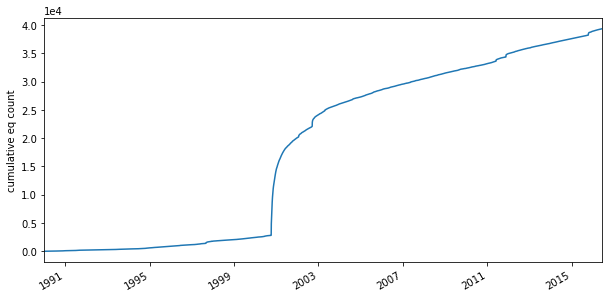

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
plotting.plot_seismicity_rate(dataframe=df_regional[df_regional.mag>=0.5], fig=fig, ax=ax)

In [8]:
df_regional = df_regional.loc[df_regional.index < eq['time']]
df_regional = df_regional[df_regional.depth <=50]
df_regional = df_regional[df_regional.mag >= 0.5]

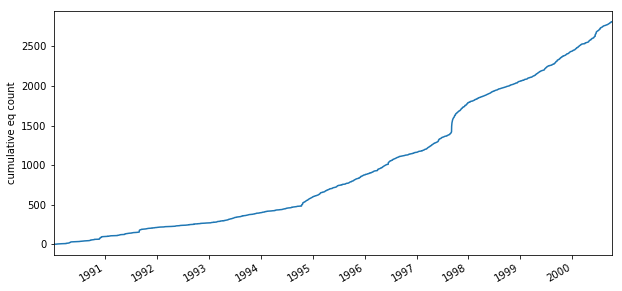

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
plotting.plot_seismicity_rate(dataframe=df_regional, fig=fig, ax=ax)
# ax.text(s='dfgdfg', x=2003, y=1000)
fig.savefig('sugura_bay_seismicity_cnt.png', dpi=300, bbox_inches='tight')

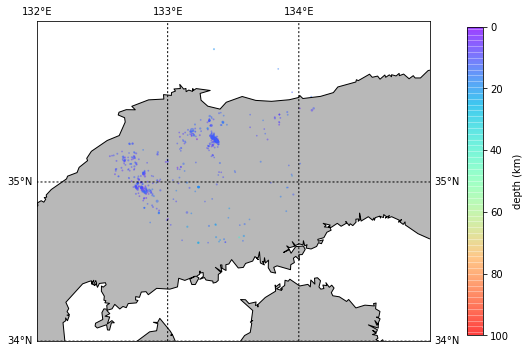

In [10]:
m, fig, ax = plotting.plot_seismicity_map(dataframe=df_regional[df_regional.mag>2])

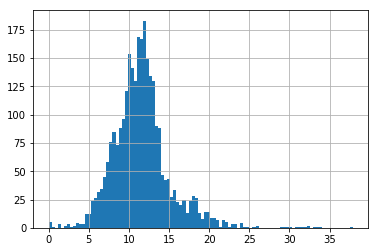

In [11]:
df_regional.depth.hist(bins=100)

In [12]:
stats.calc_fmd_stats_with_mc(df_regional.mag)

(4.3922757440172475,
 0.77365735681412551,
 1.8648017710102457e-14,
 1427,
 1.5999999999999999)

In [13]:
radii = np.arange(1, 51, 1)
foreshock_time = eq['time']

timii = pd.date_range(start='01-01-1990 00:00:00', end=foreshock_time, freq='6M', tz='GMT')
parameters = [x for x in product(radii, timii)]
df_regional = df_regional.loc[df_regional.index < foreshock_time]
# df_regional = df_regional[df_regional.mag >= 0.5]
# df_regional = df_regional[df_regional.depth <= 25]
n_iterations = 100

bdf = stats.calculate_b_value_parameter_sweep(dataframe=df_regional
                                              ,location=eq['coordinates']
                                              ,n_iterations=n_iterations
                                              ,parameters=parameters)

/home/max/pymap3/utilities/stats.py:45: RuntimeWarning: invalid value encountered in true_divide
  b_stddev = square_every_value((magnitudes - average).sum()) / (length * (length - 1))


/home/max/anaconda2/envs/research/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


(0, 50)

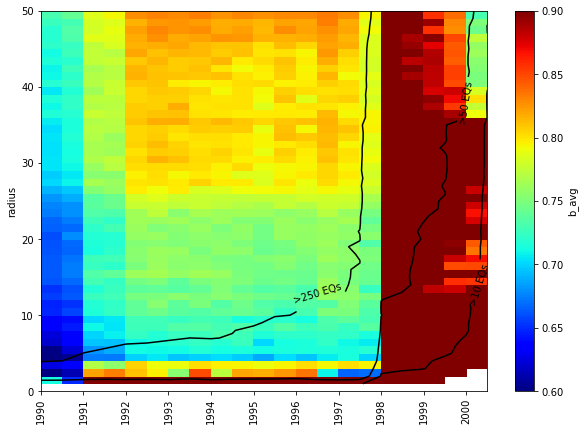

In [23]:
fig, ax = plt.subplots(figsize=(10,7))

fig, ax = plotting.plot_radius_time_sweep(dataframe=bdf, vertical_axis='radius'
                                 , value='b_avg',vmin=0.6, vmax=0.9, cmap='jet', fig=fig, ax=ax)

zi = bdf.pivot(index='start_time', columns='radius', values='n_avg')
xi_label = [np.datetime64(z, 'Y') for z in zi.index]
xi = np.arange(len(xi_label))
yi = zi.columns
xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi).transpose()

levels = [10, 50, 250, 1000, 5000]
cs = ax.contour(xi,yi,zi, levels, colors='black')#, locator=ticker.LogLocator())

cs.levels = ['>10 EQs', '>50 EQs','>250 EQs', '>1000 EQs', '>5000 EQs']

ax.clabel(cs, cs.levels, inline=True)
ax.set_ylim(0,50)


# fig.savefig('western_tottori_parameter.png', dpi=300, bbox_inches='tight', transparency=True)

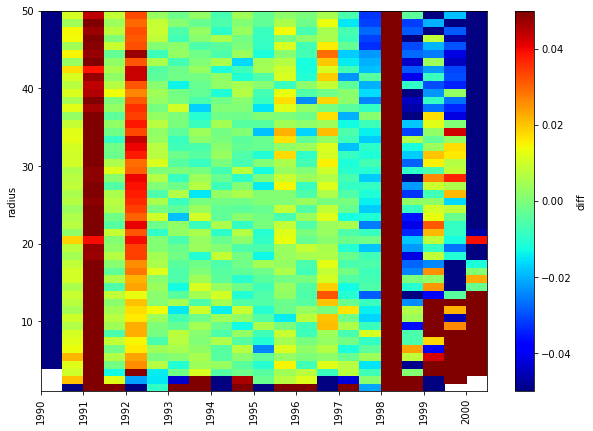

In [15]:
bdf['diff'] = bdf.b_avg.diff()

fig, ax = plt.subplots(figsize=(10,7))

fig, ax = plotting.plot_radius_time_sweep(dataframe=bdf, vertical_axis='radius'
                                 , value='diff',vmin=-0.05, vmax=0.05, cmap='jet', fig=fig, ax=ax)

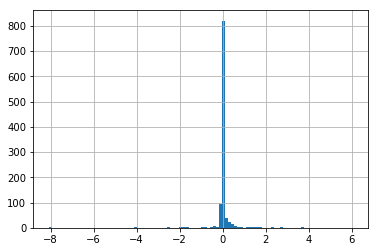

In [16]:
bdf['diff'].hist(bins=100,)

In [17]:
test = pd.DataFrame(columns=['a','b'])
test.apply(lambda x: x['a'] + 1)

,a,b


In [18]:
bdf.describe()

,radius,a_avg,b_avg,bstd_avg,n_avg,mc_avg,a_std,b_std,bstd_std,n_std,mc_std,diff
count,1100.000000,1095.000000,1095.000000,1.092000e+03,1095.000000,1095.000000,1.095000e+03,1.095000e+03,1.092000e+03,1095.000000,1.095000e+03,1092.000000
mean,25.500000,3.874409,0.941434,1.681527e-15,275.571126,1.653791,5.185849e-01,2.300513e-01,1.317630e-15,38.933680,1.140214e-01,0.007923
std,14.437434,1.373473,0.684106,7.399568e-16,175.120609,0.069442,1.484904e+00,6.061873e-01,7.485471e-16,19.373089,6.755852e-02,0.769744
min,1.000000,2.461855,0.592615,0.000000e+00,1.000000,1.204478,2.155183e-14,5.387957e-15,0.000000e+00,0.000000,1.571487e-15,-8.092416
25%,13.000000,3.534964,0.747996,1.054825e-15,94.005000,1.638000,6.956998e-02,3.905584e-02,8.803849e-16,25.891851,7.704125e-02,-0.008179
50%,25.500000,3.776593,0.795714,1.684733e-15,296.970000,1.673000,7.867545e-02,4.468201e-02,1.253258e-15,40.881469,8.418354e-02,0.001812
75%,38.000000,3.945687,0.858027,2.279067e-15,405.865000,1.688000,1.792161e-01,1.072438e-01,1.637618e-15,54.332596,1.176794e-01,0.015330
max,50.000000,22.583313,8.685890,3.547394e-15,693.120000,2.070000,9.703377e+00,3.982470e+00,1.084609e-14,82.299664,4.520436e-01,6.059658
